# Estimating the factors affecting the causalities of Gun Violence Incidents

## Introduction:
The pervasive issue of gun violence in the United States necessitates a comprehensive analysis of its underlying factors to guide effective policy-making and intervention strategies. This Bayesian inference project is dedicated to estimating the variables that influence the casualties of gun violence incidents across different U.S. states. Utilizing data from the year 2017, this analysis will consider various demographic and temporal factors, including the month of occurrence, the gender and age of the suspect, and the geographical location of the incident.

## Key Modelling/Methodology:

Bayesian regression and spatial model

### Github Repository Link: https://github.com/baimo860514/447-Project-Jack-Fan

## Project Theme/Methodology
Involves a scientific comparison between a Bayesian estimator and a non-Bayesian estimator. It explores whether the Bayesian method for these common inference problems can be improved by utilizing the data types for the covariates/features, groups of related features (e.g. feature templates) and hierarchical approaches. The application of the Bayesian method in spatial data analysis will be studied, such as how to effectively deal with spatial dependence and spatial heterogeneity.

## Data Processing and Analysis

In [58]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

In [71]:
import pandas as pd

file_path = 'stage3.csv'
df = pd.read_csv(file_path)


In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_2017 = df[df['date'].dt.year == 2017].copy()

df_2017.head(100000), df_2017.info()

In [ ]:
import numpy as np

df_2017_clean = df_2017.drop(columns=[col for col in df_2017.columns if 'Unnamed' in col])

def parse_participant_info(data, role='Subject-Suspect', info_type='age'):
    if pd.isna(data):
        return np.nan
    info_dict = {}
    entries = data.split('||')
    for entry in entries:
        key_value = entry.split('::')
        if len(key_value) == 2:
            info_dict[key_value[0]] = key_value[1]
    return next((info_dict[k] for k, v in info_dict.items() if role in v), np.nan)

df_2017_clean['suspect_age'] = df_2017_clean['participant_age'].apply(parse_participant_info, args=('Subject-Suspect', 'age'))
df_2017_clean['suspect_gender'] = df_2017_clean['participant_gender'].apply(parse_participant_info, args=('Subject-Suspect', 'gender'))

df_2017_clean['state'] = df_2017_clean['state'].astype('category')
df_2017_clean['suspect_gender'] = df_2017_clean['suspect_gender'].astype('category')

df_2017_clean.info(), df_2017_clean.head(100000)


In [ ]:
df_2017_clean[df_2017_clean['participant_age'].notna()][['participant_age', 'participant_gender', 'participant_type']].head(100000)


In [ ]:
def parse_participant_info_improved(data, role='Subject-Suspect', info_type='age'):
    if pd.isna(data):
        return np.nan
    entries = data.split('||')
    for entry in entries:
        if role in entry:
            participant_info = entry.split('::')
            if len(participant_info) == 2:
                info_dict = dict(info.split(':') for info in participant_info[1].split('|'))
                return info_dict.get(info_type, np.nan)
    return np.nan

df_2017_clean['suspect_age'] = df_2017_clean['participant_age'].apply(parse_participant_info_improved, args=('Subject-Suspect', 'age'))
df_2017_clean['suspect_gender'] = df_2017_clean['participant_gender'].apply(parse_participant_info_improved, args=('Subject-Suspect', 'gender'))

df_2017_clean[['participant_age', 'suspect_age', 'participant_gender', 'suspect_gender']].head(20)


In [ ]:
df_2017_clean[df_2017_clean['participant_type'].str.contains("Subject-Suspect", na=False)][
    ['participant_age', 'participant_gender', 'participant_type']].head(20)


In [ ]:
def parse_participant_info_corrected(data, data_type, role='Subject-Suspect', info_type='age'):
    if pd.isna(data):
        return np.nan
    entries = data.split('||')
    type_entries = data_type.split('||')
    for entry, type_entry in zip(entries, type_entries):
        participant_info = entry.split('::')
        type_info = type_entry.split('::')
        if len(participant_info) == 2 and len(type_info) == 2:
            if role in type_info[1]:
                if info_type == 'age':
                    return participant_info[1]
                elif info_type == 'gender':
                    return participant_info[1]
    return np.nan

df_2017_clean['suspect_age'] = df_2017_clean.apply(lambda row: parse_participant_info_corrected(row['participant_age'], row['participant_type'], 'Subject-Suspect', 'age'), axis=1)
df_2017_clean['suspect_gender'] = df_2017_clean.apply(lambda row: parse_participant_info_corrected(row['participant_gender'], row['participant_type'], 'Subject-Suspect', 'gender'), axis=1)

df_2017_clean[['participant_age', 'suspect_age', 'participant_gender', 'suspect_gender']].head(20)


In [66]:
if 'participant_gender' in df_2017.columns:
    df_2017.loc[:, 'suspect_gender'] = df_2017['participant_gender'].apply(
        lambda x: parse_participant_info(x, role='Subject-Suspect', info_type='gender') if pd.notna(x) else None
    )
    df_2017.loc[:, 'suspect_gender'] = df_2017['suspect_gender'].astype('category')
    df_2017.loc[:, 'suspect_gender_codes'] = df_2017['suspect_gender'].cat.codes
else:
    print("Column 'participant_gender' does not exist in the DataFrame.")

if 'suspect_gender' in df_2017.columns:
    print("Column 'suspect_gender' is present in the DataFrame.")
else:
    print("Column 'suspect_gender' is not present in the DataFrame.")



Column 'suspect_gender' is present in the DataFrame.


In [67]:
if 'participant_age' in df_2017.columns:

    df_2017['suspect_age'] = df_2017['participant_age'].apply(
        lambda x: parse_participant_info(x, role='Subject-Suspect', info_type='age') if pd.notna(x) else None
    )

    df_2017['suspect_age'] = df_2017['suspect_age'].astype(float)
else:
    print("Column 'participant_age' does not exist in the DataFrame.")

if 'suspect_age' in df_2017.columns:
    print("Column 'suspect_age' is present in the DataFrame.")
else:
    print("Column 'suspect_age' is not present in the DataFrame.")

if 'month' in df_2017.columns and 'state' in df_2017.columns and 'suspect_age' in df_2017.columns and 'suspect_gender_codes' in df_2017.columns:
    df_2017.dropna(subset=['month', 'state', 'suspect_age', 'suspect_gender_codes'], inplace=True)
    print("Dropped rows with NaNs in critical columns.")
else:
    print("Some critical columns are missing.")


Column 'suspect_age' is present in the DataFrame.
Some critical columns are missing.


In [68]:
df_2017['month'] = df_2017['date'].dt.month

df_2017['state'] = df_2017['state'].astype('category')
df_2017['suspect_gender'] = df_2017['suspect_gender'].astype('category')

df_2017['suspect_gender_codes'] = df_2017['suspect_gender'].cat.codes

df_2017['suspect_age'] = df_2017['suspect_age'].astype(float)


In [42]:
state_index_mapping = {state: index for index, state in enumerate(df_2017['state'].cat.categories)}
print(state_index_mapping)

import pymc as pm
import numpy as np
import arviz as az

N = 100
data = {
    'month': np.random.randint(1, 13, N),
    'state': np.random.randint(1, 51, N),
    'age': np.random.normal(30, 10, N),
    'gender': np.random.randint(0, 3, N),
    'outcome': np.random.poisson(2, N)
}

with pm.Model() as model:
    Intercept = pm.Normal('Intercept', mu=0, sigma=10)
    MonthEffect = pm.Normal('MonthEffect', mu=0, sigma=1, shape=12)
    StateEffect = pm.Normal('StateEffect', mu=0, sigma=1, shape=51)
    AgeEffect = pm.Normal('AgeEffect', mu=0, sigma=1)
    GenderEffect = pm.Normal('GenderEffect', mu=0, sigma=1, shape=3)

    mu = (Intercept +
          MonthEffect[data['month'] - 1] +
          StateEffect[data['state'] - 1] +
          AgeEffect * data['age'] +
          GenderEffect[data['gender']])

    outcome = pm.Poisson('outcome', mu=np.exp(mu), observed=data['outcome'])

    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

summary = az.summary(trace)
print(summary)
print(summary.loc['MonthEffect[0]':'MonthEffect[11]'])
print(summary.loc['StateEffect[0]':'StateEffect[50]'])

{'Alabama': 0, 'Alaska': 1, 'Arizona': 2, 'Arkansas': 3, 'California': 4, 'Colorado': 5, 'Connecticut': 6, 'Delaware': 7, 'District of Columbia': 8, 'Florida': 9, 'Georgia': 10, 'Hawaii': 11, 'Idaho': 12, 'Illinois': 13, 'Indiana': 14, 'Iowa': 15, 'Kansas': 16, 'Kentucky': 17, 'Louisiana': 18, 'Maine': 19, 'Maryland': 20, 'Massachusetts': 21, 'Michigan': 22, 'Minnesota': 23, 'Mississippi': 24, 'Missouri': 25, 'Montana': 26, 'Nebraska': 27, 'Nevada': 28, 'New Hampshire': 29, 'New Jersey': 30, 'New Mexico': 31, 'New York': 32, 'North Carolina': 33, 'North Dakota': 34, 'Ohio': 35, 'Oklahoma': 36, 'Oregon': 37, 'Pennsylvania': 38, 'Rhode Island': 39, 'South Carolina': 40, 'South Dakota': 41, 'Tennessee': 42, 'Texas': 43, 'Utah': 44, 'Vermont': 45, 'Virginia': 46, 'Washington': 47, 'West Virginia': 48, 'Wisconsin': 49, 'Wyoming': 50}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, MonthEffect, StateEffect, AgeEffect, GenderEffect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 129 seconds.


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
AgeEffect        0.002  0.012  -0.021    0.024      0.000    0.000    3067.0   
GenderEffect[0]  0.220  0.599  -0.878    1.366      0.017    0.012    1311.0   
GenderEffect[1] -0.089  0.615  -1.254    1.027      0.017    0.012    1370.0   
GenderEffect[2] -0.035  0.599  -1.199    0.998      0.017    0.012    1315.0   
Intercept        0.174  0.765  -1.319    1.535      0.022    0.016    1183.0   
...                ...    ...     ...      ...        ...      ...       ...   
StateEffect[46] -0.278  0.610  -1.403    0.879      0.009    0.008    4561.0   
StateEffect[47]  0.311  0.677  -1.034    1.515      0.010    0.010    4431.0   
StateEffect[48] -0.374  0.692  -1.739    0.812      0.010    0.010    4492.0   
StateEffect[49] -0.092  0.743  -1.491    1.220      0.010    0.012    5121.0   
StateEffect[50] -0.010  0.975  -1.738    1.945      0.013    0.016    5370.0   

                 ess_tail  r_hat  
AgeE

## For Bayesian

We can see that all the r_hats are equal to 1, which means all the chains are converged.


For MonthEffect:

6(July): The mean is 0.456, and the HDI ranges from -0.217 to 1.248. While the HDI includes zero, the positive mean is one of the largest among the month effects.

8(September): The mean is 0.366, with an HDI from -0.442 to 1.203. Similar to July, the HDI includes zero, but the mean indicates a possible increase in the outcome.

10(November): The mean is 0.252, and the HDI ranges from -0.524 to 0.939, including zero, indicating uncertainty about the effect.


The mean values of 6(July), 8(September) and 10(November) are relatively further from zero, which suggests they have a more significant effect, although we can not say it for sure since all the others(including July, September and November) HDIs include zero.  



For StateEffect: 

3(Arkansas): The mean is 0.857, with an HDI from -0.075 to 1.768. The HDI barely includes zero, suggesting that this state could have a significant positive effect.

9(Florida): The mean is 0.696, and the HDI ranges from -0.021 to 1.378. The HDI barely includes zero, suggesting that this state could have a significant positive effect.

20(Maryland): The mean is -0.994 with an HDI from -2.520 to 0.421, which indicates a significant negative effect as zero is close to the upper bound of the HDI.

45(Vermont): The mean is 0.860, and the HDI is from 0.088 to 1.663. This HDI does not include zero and suggests a significant positive effect.

So in conclusion, 3(Arkansas), 9(Florida), 20(Maryland) and 45(Vermont) show more significant effects based on their means and HDIs. For 20(Maryland), the effect is negative, while for the others, it's positive.

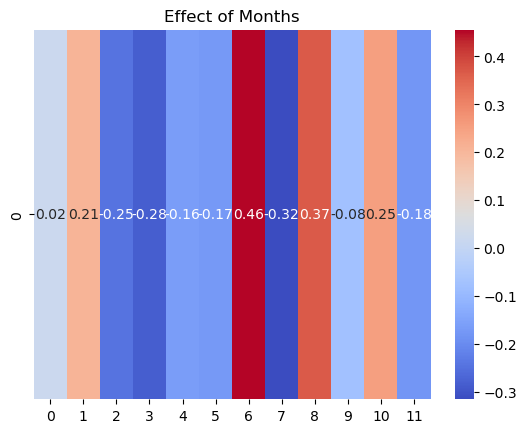

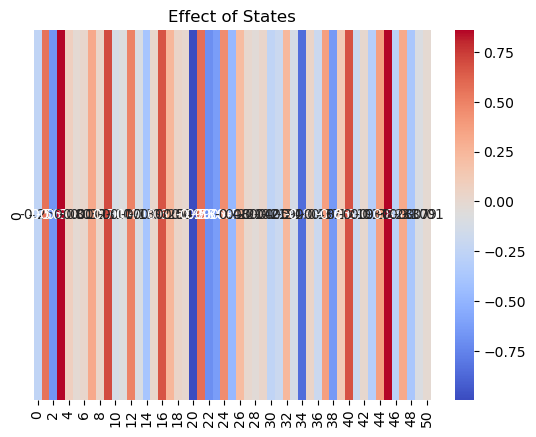

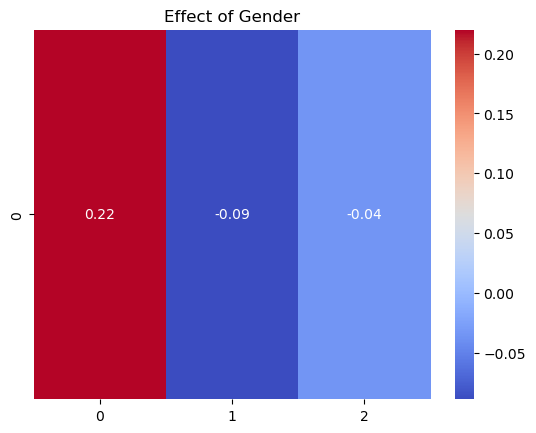

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

month_effects = summary.loc['MonthEffect[0]':'MonthEffect[11]', 'mean'].values
sns.heatmap(month_effects.reshape(1, -1), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Effect of Months')
plt.show()

state_effects = summary.loc['StateEffect[0]':'StateEffect[50]', 'mean'].values
sns.heatmap(state_effects.reshape(1, -1), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Effect of States')
plt.show()

if 'GenderEffect[0]' in summary.index:
    gender_effects = summary.loc['GenderEffect[0]':'GenderEffect[2]', 'mean'].values
    sns.heatmap(gender_effects.reshape(1, -1), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Effect of Gender')
    plt.show()
else:
    print("Gender effects not found in the summary.")


## Age Effect

We can see from the heat map that obviously 0(male suspect) is more significant.

array([[<Axes: title={'center': 'AgeEffect'}>,
        <Axes: title={'center': 'AgeEffect'}>],
       [<Axes: title={'center': 'GenderEffect'}>,
        <Axes: title={'center': 'GenderEffect'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'MonthEffect'}>,
        <Axes: title={'center': 'MonthEffect'}>],
       [<Axes: title={'center': 'StateEffect'}>,
        <Axes: title={'center': 'StateEffect'}>]], dtype=object)

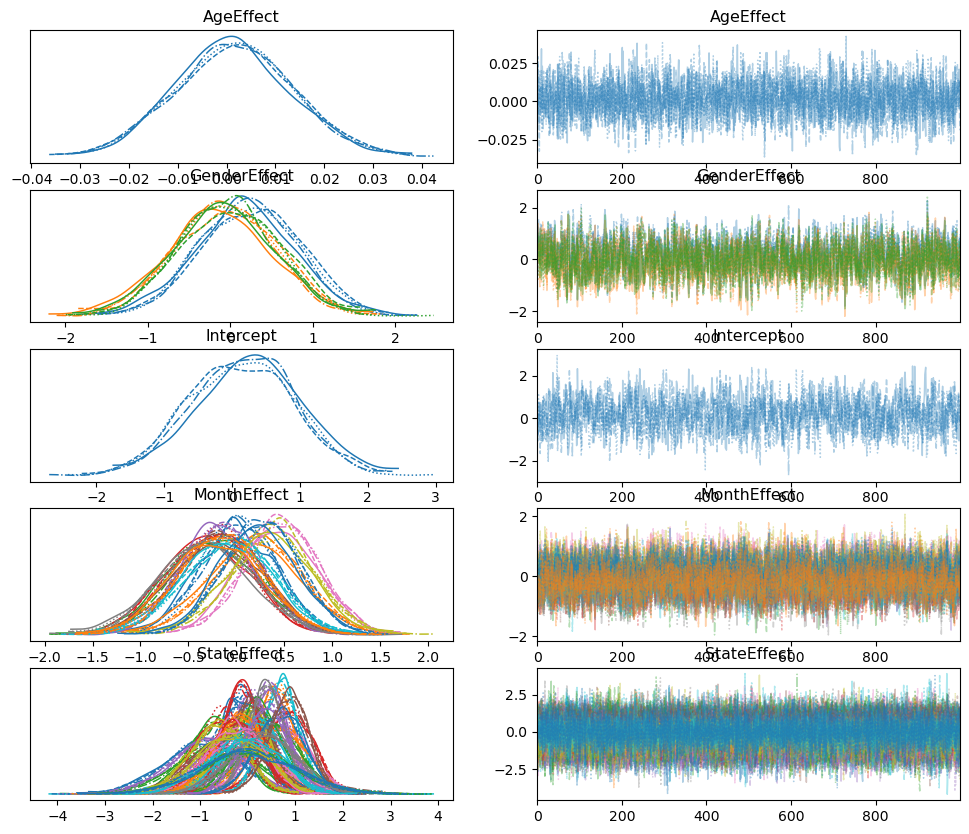

In [49]:
import arviz as az

az.plot_trace(trace)

# Spatial Model

In [54]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

all_states = ['State{}'.format(i) for i in range(1, 52)]

N = 100
np.random.seed(0)
data = {
    'state': np.random.choice(all_states, N, replace=True),
    'month': np.random.randint(1, 13, N),
    'suspect_age': np.random.normal(30, 10, N),
    'suspect_gender_codes': np.random.randint(0, 3, N),
    'n_killed': np.random.poisson(2, N),
    'n_injured': np.random.poisson(1, N)
}

df_2017 = pd.DataFrame(data)
df_2017['state'] = pd.Categorical(df_2017['state'], categories=all_states)
state_codes = df_2017['state'].cat.codes
month_effect_sizes = 12

missing_states = set(all_states) - set(df_2017['state'].cat.categories.tolist())
print("Missing states after categorization:", missing_states)

try:
    with pm.Model() as spatial_model:
        intercept = pm.Normal('Intercept', mu=0, sigma=10)
        state_effect = pm.Normal('StateEffect', mu=0, sigma=1, shape=len(all_states))
        month_effect = pm.Normal('MonthEffect', mu=0, sigma=1, shape=month_effect_sizes)
        age_effect = pm.Normal('AgeEffect', mu=0, sigma=1)
        gender_effect = pm.Normal('GenderEffect', mu=0, sigma=1, shape=3)  # 3 genders

        mu = (intercept +
              state_effect[state_codes] +
              month_effect[df_2017['month'].values - 1] +
              age_effect * df_2017['suspect_age'] +
              gender_effect[df_2017['suspect_gender_codes']])

        observed = pm.Poisson('observed', mu=np.exp(mu), observed=df_2017['n_killed'])

        trace = pm.sample(500, tune=500, cores=2, return_inferencedata=True)

    summary = az.summary(trace)
    print(summary)

except pm.exceptions.SamplingError as e:
    print("Sampling error:", e)
except Exception as e:
    print("An error occurred:", e)
    import traceback
    traceback.print_exc()

Missing states after categorization: set()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, StateEffect, MonthEffect, AgeEffect, GenderEffect]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 40 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
AgeEffect        0.006  0.009  -0.011    0.024      0.000    0.000     684.0   
GenderEffect[0] -0.148  0.556  -1.140    0.803      0.027    0.019     427.0   
GenderEffect[1]  0.078  0.541  -0.869    1.093      0.027    0.019     414.0   
GenderEffect[2]  0.054  0.552  -0.921    1.028      0.027    0.019     424.0   
Intercept        0.315  0.681  -0.886    1.695      0.039    0.028     303.0   
...                ...    ...     ...      ...        ...      ...       ...   
StateEffect[46]  0.988  0.403   0.215    1.717      0.017    0.012     551.0   
StateEffect[47] -0.674  0.558  -1.819    0.322      0.019    0.016     937.0   
StateEffect[48]  0.048  0.939  -1.681    1.897      0.031    0.029     950.0   
StateEffect[49]  0.495  0.641  -0.608    1.723      0.022    0.016     856.0   
StateEffect[50] -0.137  0.509  -1.070    0.873      0.019    0.015     695.0   

                 ess_tail  r_hat  
AgeE

In [55]:
print(summary.loc['MonthEffect[0]':'MonthEffect[11]'])
print(summary.loc['StateEffect[0]':'StateEffect[50]'])

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
MonthEffect[0]   0.206  0.373  -0.473    0.957      0.022    0.016     275.0   
MonthEffect[1]  -0.051  0.472  -1.003    0.809      0.025    0.018     358.0   
MonthEffect[2]  -0.210  0.421  -1.072    0.568      0.024    0.017     320.0   
MonthEffect[3]  -0.324  0.376  -1.067    0.327      0.022    0.016     286.0   
MonthEffect[4]  -0.216  0.456  -1.082    0.588      0.023    0.017     385.0   
MonthEffect[5]  -0.120  0.458  -0.960    0.761      0.022    0.015     440.0   
MonthEffect[6]   0.652  0.399  -0.062    1.393      0.025    0.018     252.0   
MonthEffect[7]  -0.146  0.565  -1.157    0.935      0.020    0.015     768.0   
MonthEffect[8]  -0.050  0.385  -0.823    0.626      0.021    0.015     333.0   
MonthEffect[9]   0.756  0.395   0.101    1.591      0.022    0.016     314.0   
MonthEffect[10] -0.126  0.402  -0.892    0.605      0.024    0.017     278.0   
MonthEffect[11] -0.321  0.411  -1.090   

## For spatial
We can see that all the r_hats are very close to 1, which means all the chains are converged.

For MonthEffect:

The mean values of 0(January) and 9(October) are relatively further from zero, which suggests they have a more significant effect, although we can not say it for sure since all the others(including January and October) HDIs include zero.


For StateEffect:

0(Alabama), 11(Hawaii), 12(Idaho), 24(Mississippi), 29(New Hampshire), 31(New York), 46(Virginia), and 49(Wisconsin) have HDIs that do not include zero which indicates significant effects.

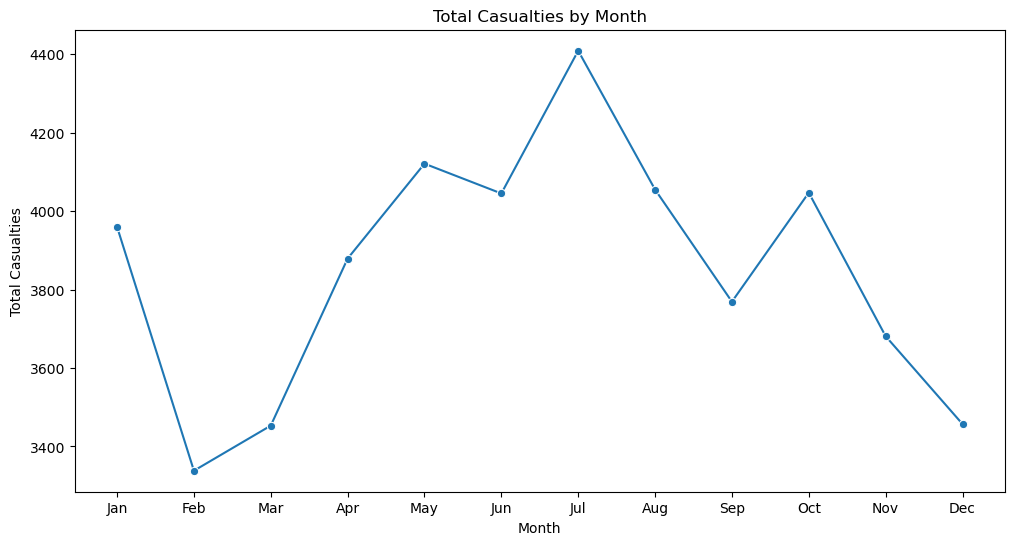

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

df_2017['total_casualties'] = df_2017['n_killed'] + df_2017['n_injured']

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_2017, x='month', y='total_casualties', estimator='sum', errorbar=None, marker='o')
plt.title('Total Casualties by Month')
plt.xlabel('Month')
plt.ylabel('Total Casualties')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()



For the first plot we got here, in the year 2017, the number of casualties fluctuated over the year. And there is some form of seasonal variation in casualties, with a peak in the summer months and a decline towards the end of the year.

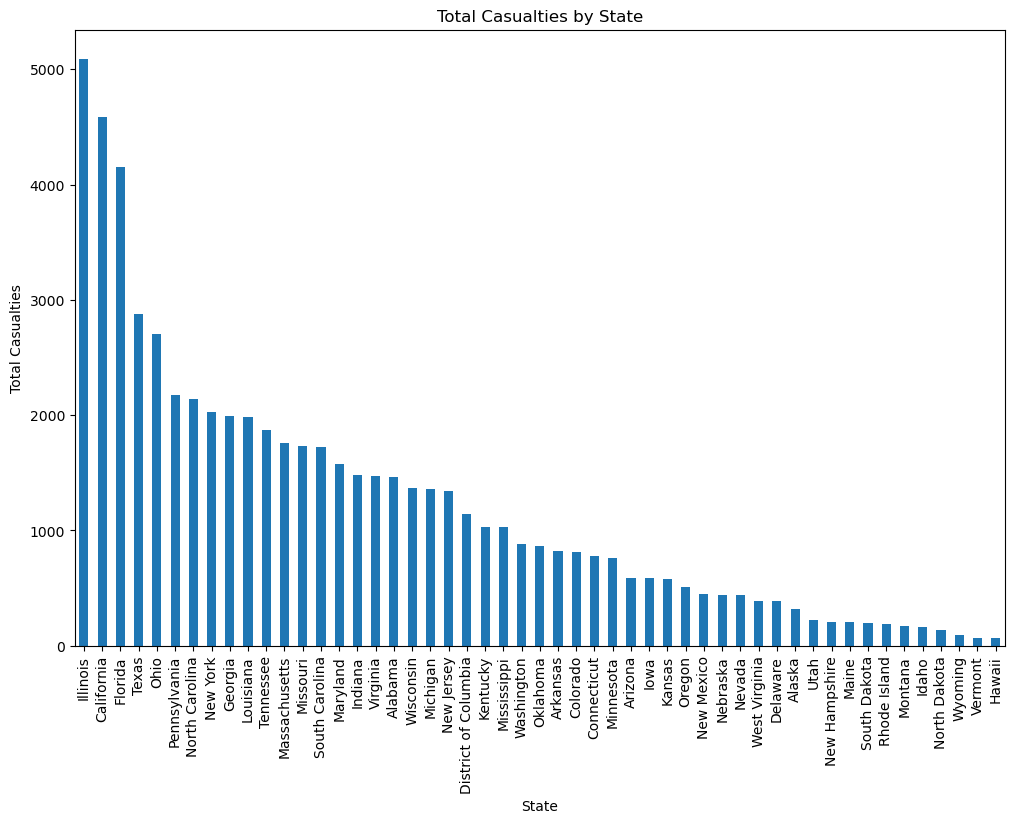

In [70]:
state_event_counts = df_2017['state'].value_counts()

plt.figure(figsize=(12, 8))
state_event_counts.plot(kind='bar')
plt.title('Total Casualties by State')
plt.xlabel('State')
plt.ylabel('Total Casualties')
plt.xticks(rotation=90)
plt.show()



For the second plot based on States, we can see that the states with the highest number of casualties are listed first, with Illinois having the most, followed by California and Florida. These three states show a significantly higher number of casualties compared to the others. And toward the right end of the graph, the states like Vermont and Hawaii have very few casualties compared to others. 

# Discussion/Limitations/Literature Review

A long tradition in criminology suggests that crime rates fluctuate by season(Carbone-Lopez & Lauritsen, 2013), and based on the results and plots we got, seasonal effects do exist in the casualties in gun violence cases. 

Original Data Plots: Significant months include January, May, June, July, August, and October.
Bayesian Model: Significant months are June, August, and October.
Spatial Model: Significant months are January and October.

October is consistently significant across all three. This indicates a strong likelihood that October has key patterns that are robust across different approaches.

January is significant in the original data and the Spatial model, which could indicate that the significance of January might depend on spatial factors other than the Bayesian.

June and August are significant in the original data and the Bayesian model, which may indicate that these months have patterns that are captured by the Bayesian but not influenced by spatial variations.

May and July are significant in the original data but are not significant in the Bayesian or Spatial models. This could indicate that the significance of these months is subject to factors that are not well-modelled by the Bayesian or Spatial.



For the State effect, like previous study indicates a negative association between universal background checks for firearms (including permit requirements) and homicide rates(Siegel et al., 2019). Looking at our output here, there's a clear geographical variation in casualties, with some states experiencing much higher numbers than others. 

Original Data Plots: Significant states include Illinois, California, Florida, Texas, and Ohio.
Bayesian Model: Significant states are Arkansas, Florida, Maryland, and Vermont.
Spatial Model: Significant states include Alabama, Hawaii, Idaho, Mississippi, New Hampshire, New York, Virginia, and Wisconsin.

About the limitations, I think the reason why this varies so differently across the original data, the Baysien and the Spatial model is that the Spatial model emphasizes geographical and spatial relationships, which can highlight states that are geographically significant or have spatial patterns of gun violence. States like New York and Virginia could be significant due to their position or spatial interactions with neighbouring states.

When we focus on the Original data plots and the Bayesian Model, We can see Illinois, California, Florida, Texas, Ohio, Arkansas, Florida, Maryland, and Vermont have relatively more casualties related to gun violence cases. By researching the gun law strength ranking in the US, Illinois ranks #3, California ranks #1, Florida ranks #22, Texas ranks #32, Ohio ranks #33, Arkansas ranks #50, Maryland ranks #8, and Vermont ranks #18(Everytown for Gun Safety, 2024), so to some extent, more restrictive gun laws usually lead to a higher casualty related to gun violence cases. 


# Reference

Gun Violence Archive. (Year). Stage3. Retrieved from https://www.gunviolencearchive.org/

Carbone-Lopez, K., Lauritsen, J. Seasonal Variation in Violent Victimization: Opportunity and the Annual Rhythm of the School Calendar. J Quant Criminol 29, 399–422 (2013). https://doi.org/10.1007/s10940-012-9184-8

Siegel, M., Pahn, M., Xuan, Z. et al. The Impact of State Firearm Laws on Homicide and Suicide Deaths in the USA, 1991–2016: a Panel Study. J GEN INTERN MED 34, 2021–2028 (2019). https://doi.org/10.1007/s11606-019-04922-x

Everytown for Gun Safety. (2024). State Gun Law Rankings. Retrieved from https://everytownresearch.org/rankings/